In [1]:
import numpy as np
import matplotlib.pyplot as plt

We consider a Brownian motion starting at $x=x_0$
$$
X(t)=x_0+W(t)
$$
hitting two square root boundaries
$$
u(t)=a\sqrt{t-T},\quad \ell(t)=-b\sqrt{t-T}
$$

This is the example in section A.4, where we quantitatively study the numerical error of the presented algorithm.

In [2]:
T = 5.0
a = 0.6
b = 0.4
x0 = 0.1

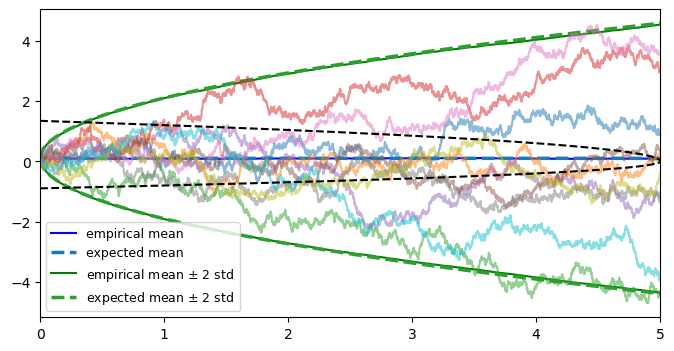

In [3]:
from efficient_fpt.models import DDModel


class SqrtBdyDDModel(DDModel):
    def __init__(self, a, b, T, x0):
        super().__init__(x0)
        self.a = a
        self.b = b
        self.T = T
        self.x0 = x0

    def drift_coeff(self, X: float, t: float) -> float:
        return 0

    def diffusion_coeff(self, X: float, t: float) -> float:
        return 1

    @property
    def is_update_vectorizable(self):
        return True

    def upper_bdy(self, t):
        return np.sqrt(self.T - t) * self.a

    def lower_bdy(self, t):
        return -np.sqrt(self.T - t) * self.b


num = 10000


ddm = SqrtBdyDDModel(a=a, b=b, T=T, x0=x0)
t_grid, X_grids = ddm.simulate_trajs(T=T, Nt=1000 * T, num=num)


expected_mean = x0 * np.ones_like(t_grid)
empirical_mean = np.mean(X_grids, axis=0)
expected_std = np.sqrt(t_grid)
empirical_std = np.std(X_grids, axis=0)


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t_grid, empirical_mean, label="empirical mean", c="b")
ax.plot(
    t_grid,
    expected_mean,
    label="expected mean",
    linewidth=2.5,
    linestyle="--",
    c="tab:blue",
)
ax.plot(
    t_grid,
    empirical_mean + 2 * empirical_std,
    label=r"empirical mean $\pm$ 2 std",
    c="g",
)
ax.plot(t_grid, empirical_mean - 2 * empirical_std, c="g")
ax.plot(
    t_grid,
    expected_mean + 2 * expected_std,
    label=r"expected mean $\pm$ 2 std",
    linewidth=2.5,
    linestyle="--",
    c="tab:green",
)
ax.plot(
    t_grid,
    expected_mean - 2 * expected_std,
    linewidth=2.5,
    linestyle="--",
    c="tab:green",
)
ax.plot(t_grid, X_grids[:10, :].T, alpha=0.5)
ax.plot(t_grid, ddm.upper_bdy(t_grid), c="k", linestyle="--")
ax.plot(t_grid, ddm.lower_bdy(t_grid), c="k", linestyle="--")
ax.autoscale(axis="x", tight=True)
ax.legend(fontsize=9)
plt.show()

To obtain reference values for the FPTDs, we apply the time change $s=\log(T/(T-t))$, which transforms the original problem into a first passage time problem for the (unstable) Ornstein–Uhlenbeck process
\begin{equation*}
\mathrm{d} \widetilde{X}(s)=\frac{1}{2} \widetilde{X}(s) \mathrm{d} s+\mathrm{d}  \widetilde{W}(s),
\end{equation*}
where 
\begin{equation*}
\widetilde{W}(s)=\int_0^{T(1-e^{-s})} \frac{1}{\sqrt{T-r}} \mathrm{d} W(r)
\end{equation*}
is another standard Brownian motion. Under this transformation, the two absorbing boundaries become constant:
\begin{equation*}
\widetilde{u}(s)=a,\quad \widetilde{\ell}(s)=b.
\end{equation*}

To get reference FPTDs, we solve the Kolmogorov forward equation governing the transformed problem

\begin{equation*}
\begin{aligned}
\partial_s u&=\tfrac{1}{2} u_{zz}-\tfrac{1}{2} z u_{z}-\tfrac{1}{2} u, \quad z \in(-b, a), s>0\\
u(z, 0)&=\delta(z-x_0/\sqrt{T}),\quad z \in(-b, a) \\
u(a, s)&=0, u(-b, s)=0,\quad s>0
\end{aligned}
\end{equation*}
and the FPTDs are given by
\begin{equation*}
f_u(t)=-\tfrac{1}{2(T-t)}\partial_z u(a, \log(\tfrac{T}{T-t})),\quad f_\ell(t)=\tfrac{1}{2(T-t)}\partial_z u(-b, \log(\tfrac{T}{T-t}))
\end{equation*}

The weak form of the PDE is given by
\begin{equation*}
\int_{-b}^a v \partial_s u ~\mathrm{d} z=-\frac{1}{2} \int_{-b}^a v_z u_z ~\mathrm{d} z+\frac{1}{2} \int_{-b}^a z v_z u ~\mathrm{d} z, \quad \forall v \in H_0^1((-b, a)) .
\end{equation*}
We use a highly accurate spectral element method to discretize and solve the PDE.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from functools import lru_cache
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import expm_multiply


def gll_nodes_weights(p: int):
    """Gauss-Lobatto-Legendre nodes/weights on [-1,1] for degree p."""
    if p < 1:
        raise ValueError("p must be >= 1")
    Pp = np.polynomial.legendre.Legendre.basis(p)
    dPp = Pp.deriv()

    if p == 1:
        xi = np.array([-1.0, 1.0], dtype=np.float64)
    else:
        r = np.sort(dPp.roots())
        xi = np.concatenate(([-1.0], r, [1.0])).astype(np.float64)

    Pp_x = Pp(xi)
    w = 2.0 / (p * (p + 1) * (Pp_x**2))
    return xi, w.astype(np.float64)


def barycentric_weights(x_nodes: np.ndarray):
    """
    barycentric weights for the Language interpolation nodes, computed in log-space
    Only ratios matter, so global scaling is irrelevant.
    """
    x = np.asarray(x_nodes, dtype=np.float64)
    n = x.size

    logabs = np.empty(n, dtype=np.float64)
    sgn = np.empty(n, dtype=np.float64)

    # O(n^2) but n=p+1 is small
    for j in range(n):
        diff = x[j] - x
        diffj = np.delete(diff, j)
        sgn[j] = np.prod(np.sign(diffj))
        logabs[j] = np.sum(np.log(np.abs(diffj)))

    m = np.min(logabs)
    bw = sgn * np.exp(-(logabs - m))
    bw /= np.max(np.abs(bw))
    return bw.astype(np.float64)


def gll_diff_matrix(x_nodes: np.ndarray, bary_w: np.ndarray):
    """barycentric differentiation matrix on given nodes."""
    x = np.asarray(x_nodes, dtype=np.float64)
    w = np.asarray(bary_w, dtype=np.float64)

    dX = x[:, None] - x[None, :]
    with np.errstate(divide="ignore", invalid="ignore"):
        D = (w[None, :] / w[:, None]) / dX

    np.fill_diagonal(D, 0.0)
    np.fill_diagonal(D, -np.sum(D, axis=1))
    return D.astype(np.float64)


def lagrange_values_at_point(x_nodes: np.ndarray, bary_w: np.ndarray, x0: float):
    """Lagrange basis values at x0 using barycentric weights."""
    x = np.asarray(x_nodes, dtype=np.float64)
    w = np.asarray(bary_w, dtype=np.float64)

    diff = x0 - x
    hit = np.where(np.abs(diff) < 1e-15)[0]
    if hit.size > 0:
        l = np.zeros_like(x)
        l[hit[0]] = 1.0
        return l

    tmp = w / diff
    return (tmp / np.sum(tmp)).astype(np.float64)


@lru_cache(maxsize=None)
def sem_reference(p: int):
    """
    Cache reference SEM objects depending only on p:
      - GLL nodes, weights
      - stable barycentric weights
      - ref differentiation matrix
    """
    xi, w_ref = gll_nodes_weights(p)
    bw = barycentric_weights(xi)
    D_ref = gll_diff_matrix(xi, bw)
    return xi, w_ref, bw, D_ref


@lru_cache(maxsize=None)
def sem_index_mapping(E: int, p: int):
    """
    Cache uniform mesh connectivity (depends only on E,p):
      - gidx: (E, nloc) global node ids per element
      - rows, cols: (E, nloc*nloc) COO indices for block assembly
    """
    if E < 1:
        raise ValueError("E must be >= 1")
    if p < 1:
        raise ValueError("p must be >= 1")

    nloc = p + 1
    gidx = (np.arange(E)[:, None] * p + np.arange(nloc)[None, :]).astype(np.int64)

    rows = np.repeat(gidx, nloc, axis=1)  # (E, nloc*nloc)
    cols = np.tile(gidx, (1, nloc))  # (E, nloc*nloc)
    return gidx, rows, cols


def sem_matrix_assemble(L, U, E, p):
    """
    matrix assembly for O-U KFE on uniform mesh with SEM (GLL nodes).

    Weak form:
        M u' = -0.5 (C + K) u
    with diagonal M from GLL quadrature and mass lumping.

    Returns the interior operator L_int plus precomputed boundary derivative
    functionals bL, bU so boundary fluxes are cheap.
    """
    if E < 2:
        raise ValueError("E must be >= 2 so that an interior exists.")
    if p < 1:
        raise ValueError("p must be >= 1")

    xi, w_ref, bw, D_ref = sem_reference(p)
    nloc = p + 1

    h = (U - L) / E
    N = E * p + 1
    interior = np.arange(1, N - 1, dtype=np.int64)
    Nint = interior.size
    if Nint <= 0:
        raise ValueError("No interior nodes. Increase E and/or p.")

    # element midpoints
    mids = L + (np.arange(E, dtype=np.float64) + 0.5) * h

    # --- local matrices ---
    # K_e = (2/h) * D^T diag(w) D
    K0 = D_ref.T @ (w_ref[:, None] * D_ref)
    K_e = (2.0 / h) * K0

    # C_e = mid * (D^T diag(w)) + (h/2) * (D^T diag(w*xi))
    # Avoid np.diag allocations via broadcasting
    G0 = D_ref.T * w_ref[None, :]  # D^T diag(w)
    G1 = D_ref.T * (w_ref * xi)[None, :]  # D^T diag(w*xi)

    C_const = (h / 2.0) * G1
    A_base = K_e - C_const

    Ab_flat = A_base.reshape(-1)
    G0_flat = G0.reshape(-1)

    # --- diagonal mass assembly ---
    M_diag = np.zeros(N, dtype=np.float64)
    W_phys = (h / 2.0) * w_ref

    gidx_nodes, rows, cols = sem_index_mapping(E, p)

    np.add.at(M_diag, gidx_nodes.ravel(), np.broadcast_to(W_phys, (E, nloc)).ravel())

    # --- sparse A assembly ---
    vals = Ab_flat[None, :] - mids[:, None] * G0_flat[None, :]
    A = coo_matrix((vals.ravel(), (rows.ravel(), cols.ravel())), shape=(N, N)).tocsr()

    # interior restriction
    A_int = A[interior][:, interior]
    M_int = M_diag[interior]
    invM = 1.0 / M_int

    # L_int = -0.5 M^{-1} A, the evolution operator over interior unknowns
    L_int = (-0.5) * (A_int.multiply(invM[:, None])).tocsr()

    # --- precompute boundary derivative functionals over interior unknowns ---
    # u_z = (2/h) * D_ref * u_loc
    scale = 2.0 / h
    g2i = -np.ones(N, dtype=np.int64)
    g2i[interior] = np.arange(Nint, dtype=np.int64)

    bL = np.zeros(Nint, dtype=np.float64)
    bU = np.zeros(Nint, dtype=np.float64)

    first = gidx_nodes[0]
    last = gidx_nodes[-1]
    drow_L = D_ref[0, :]
    drow_U = D_ref[-1, :]

    for j in range(nloc):
        ii = g2i[first[j]]
        if ii >= 0:
            bL[ii] += scale * drow_L[j]
        ii = g2i[last[j]]
        if ii >= 0:
            bU[ii] += scale * drow_U[j]

    return {
        "L_int": L_int,
        "M_diag": M_diag,
        "xi": xi,
        "w_ref": w_ref,
        "bary_w": bw,
        "D_ref": D_ref,
        "h": h,
        "E": E,
        "p": p,
        "N": N,
        "interior": interior,
        "bL": bL,
        "bU": bU,
        "L": L,
        "U": U,
        "mids": mids,
    }


def solve_fptd(
    T=1.0,
    a=1.0,
    b=1.0,
    x0=0.0,
    E=40,
    p=10,
    Nt=2000,  # number of uniform time points in t
    t_min=0.0,
    t_max=None,  # must be < T
):
    """
    BM with collapsing sqrt boundaries:
        upper: +a*sqrt(T-t)
        lower: -b*sqrt(T-t)

    Uses OU transform and SEM discretization on z in (-b, a).
    Returns FPTDs on a UNIFORM grid in physical time t.

    Time marching by expm_multiply ~Nt times.
    """
    if t_max is None:
        # default: avoid hitting exactly T
        t_max = T * (1.0 - 1e-6)

    if not (0.0 <= t_min < t_max < T):
        raise ValueError("Need 0 <= t_min < t_max < T.")

    # transform initial condition
    Lz, Uz = -b, a
    z0 = x0 / np.sqrt(T)
    if not (Lz < z0 < Uz):
        raise ValueError(f"z0=x0/sqrt(T)={z0} must lie inside (-b,a)=({Lz},{Uz}).")

    # assemble operator
    sem = sem_matrix_assemble(Lz, Uz, E, p)
    L_int, M_diag, xi, bw, h, interior, bL, bU, N = (
        sem["L_int"],
        sem["M_diag"],
        sem["xi"],
        sem["bary_w"],
        sem["h"],
        sem["interior"],
        sem["bL"],
        sem["bU"],
        sem["N"],
    )

    # initial condition (delta function at z0)
    # get element index containing z0
    e0 = int(np.floor((z0 - Lz) / h))
    e0 = min(max(e0, 0), E - 1)

    zl = Lz + e0 * h
    mid = zl + 0.5 * h
    J = 0.5 * h
    xi0 = (z0 - mid) / J

    lvals = lagrange_values_at_point(xi, bw, xi0)

    u0 = np.zeros(N, dtype=np.float64)
    nodes_e0 = (e0 * p + np.arange(p + 1)).astype(np.int64)
    u0[nodes_e0] += lvals / M_diag[nodes_e0]

    # Dirichlet boundary conditions
    u0[0] = 0.0
    u0[-1] = 0.0
    u_int = u0[interior].copy()

    # ---- uniform t grid
    t_grid = np.linspace(t_min, t_max, Nt)
    # map t -> s(t) = -log(1 - t/T)
    s_grid = -np.log1p(-t_grid / T)

    # ---- propagate in varying ds, calling expm_multiply each step
    g_upper = np.empty(Nt, dtype=np.float64)
    g_lower = np.empty(Nt, dtype=np.float64)

    # start at first time point s0
    s0 = s_grid[0]
    if np.isclose(s0, 0.0): # u(s0) = u(0)
        u = u_int
    else: # u(s0) = exp(L*s0) u(0)
        u = expm_multiply(L_int, u_int, start=0.0, stop=s0, num=2)[-1]

    # flux at s0
    pz_L = float(u @ bL)
    pz_U = float(u @ bU)
    g_lower[0] = max(+0.5 * pz_L, 0.0)
    g_upper[0] = max(-0.5 * pz_U, 0.0)

    # step forward
    for k in range(1, Nt):
        ds = s_grid[k] - s_grid[k - 1]
        if ds <= 0:
            raise RuntimeError("s_grid must be strictly increasing (check t_grid).")

        # u <- exp(L*ds) u
        u = expm_multiply(L_int, u, start=0.0, stop=ds, num=2)[-1]

        pz_L = float(u @ bL)
        pz_U = float(u @ bU)
        g_lower[k] = max(+0.5 * pz_L, 0.0)
        g_upper[k] = max(-0.5 * pz_U, 0.0)

    # ---- map flux in s -> density in t: f(t) = g(s(t)) / (T - t)
    tau = T - t_grid
    f_upper = g_upper / tau
    f_lower = g_lower / tau

    # mass check in t
    mass_t = np.trapz(f_upper + f_lower, t_grid)

    return t_grid, f_upper, f_lower, mass_t

In [5]:
# solve

Nt = 10000

t, fu, fl, mt = solve_fptd(
    T=T,
    a=a,
    b=b,
    x0=x0,
    E=50,
    p=10,
    Nt=Nt,  # uniform in t
    t_min=0,  # avoid exact 0 if you want
    t_max=T * (1.0 - 1 / Nt),  # avoid t ~ T
)

print(f"Mass over returned t-range: {mt:.10f}")

Mass over returned t-range: 1.0000000000


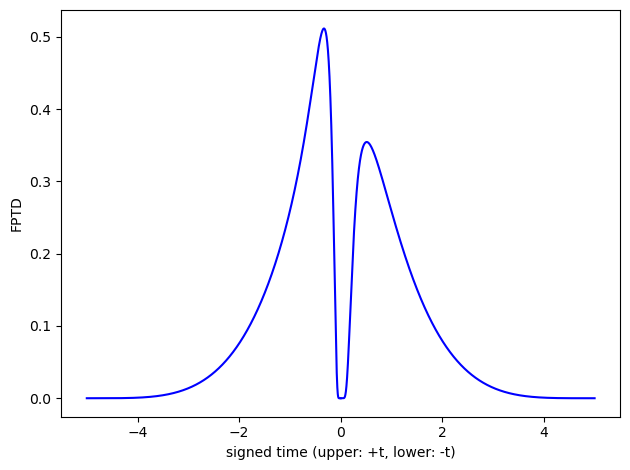

In [6]:
plt.figure()
plt.plot(t, fu, label="upper FPTD (+t)", c="b")
plt.plot(-t[::-1], fl[::-1], label="lower FPTD (-t)", c="b")
plt.xlabel("signed time (upper: +t, lower: -t)")
plt.ylabel("FPTD")
# plt.legend()
plt.tight_layout()
plt.show()

In [7]:
from efficient_fpt.utils import adaptive_interpolation
from efficient_fpt.multi_stage import get_multistage_densities

In [8]:
u_bdy = lambda t: a * np.sqrt(T - t)
l_bdy = lambda t: -b * np.sqrt(T - t)


#### Check errors for different interpolation threshold

In [9]:
intp_shreshold_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
ts_list = []
upper_fptds_list = []
lower_fptds_list = []
for k, intp_threshold in enumerate(intp_shreshold_list):
    t_intp_array, _ = adaptive_interpolation(
        u_bdy, [0, T], intp_threshold, initial_points=1
    )
    b1_array = (u_bdy(t_intp_array)[1:] - u_bdy(t_intp_array)[:-1]) / (
        t_intp_array[1:] - t_intp_array[:-1]
    )
    b2_array = (l_bdy(t_intp_array)[1:] - l_bdy(t_intp_array)[:-1]) / (
        t_intp_array[1:] - t_intp_array[:-1]
    )
    a1 = u_bdy(0)
    a2 = l_bdy(0)
    mu_array = np.zeros_like(b1_array)
    sigma_array = np.ones_like(b1_array)
    sacc_array = t_intp_array[:-1]

    eps = 0  # 1e-5
    ts = np.linspace(0, T, 1001)
    fptds, npds = get_multistage_densities(
        ts,
        mu_array,
        sacc_array,
        sigma_array,
        a1,
        b1_array,
        a2,
        b2_array,
        T,
        x0=np.array([[1], [x0]]),
        eps=eps,
    )
    ts, upper_fptds, lower_fptds = fptds[0, :], fptds[1, :], fptds[2, :]

    ts_list.append(ts)
    upper_fptds_list.append(upper_fptds)
    lower_fptds_list.append(lower_fptds)
    # print(len(sacc_array), len(ts))


for k, (ts, upper_fptds, lower_fptds) in enumerate(
    zip(ts_list, upper_fptds_list, lower_fptds_list)
):
    idx = np.searchsorted(t, ts)

    fu_ref = fu[idx]
    fl_ref = fl[idx]

    # ---- max absolute error (L-infinity) ----
    abs_err_u = np.max(np.abs(fu_ref - upper_fptds))
    abs_err_l = np.max(np.abs(fl_ref - lower_fptds))
    abs_err = max(abs_err_u, abs_err_l)

    # ---- Total Variation distance (TV) ----
    # L1 error for each density, then TV = 0.5 * L1
    # Use a simple Riemann sum on the ts grid; assumes ts is sorted.
    dts = np.diff(ts)
    # weights for trapezoid rule (more accurate than left-sum)
    w = np.empty_like(ts, dtype=float)
    w[0] = dts[0] / 2
    w[-1] = dts[-1] / 2
    w[1:-1] = (dts[:-1] + dts[1:]) / 2

    l1_u = np.sum(np.abs(fu_ref - upper_fptds) * w)
    l1_l = np.sum(np.abs(fl_ref - lower_fptds) * w)

    tv_u = 0.5 * l1_u
    tv_l = 0.5 * l1_l
    tv_total = 0.5 * (l1_u + l1_l)

    print(
        # f"k={k:02d} | "
        f"eps={intp_shreshold_list[k]:0e} | "
        f"Linf_abs={abs_err:.3e} (upper={abs_err_u:.3e}, lower={abs_err_l:.3e}) | "
        f"TV_total={tv_total:.3e} (upper={tv_u:.3e}, lower={tv_l:.3e}) | "
        # f"mass={np.trapz(upper_fptds + lower_fptds, ts)}"
    )

eps=1.000000e-01 | Linf_abs=1.705e-02 (upper=1.705e-02, lower=1.391e-02) | TV_total=2.134e-02 (upper=1.159e-02, lower=9.743e-03) | 
eps=1.000000e-02 | Linf_abs=2.245e-03 (upper=2.245e-03, lower=2.133e-03) | TV_total=1.849e-03 (upper=9.911e-04, lower=8.575e-04) | 
eps=1.000000e-03 | Linf_abs=7.291e-04 (upper=6.282e-04, lower=7.291e-04) | TV_total=5.297e-04 (upper=2.834e-04, lower=2.463e-04) | 
eps=1.000000e-04 | Linf_abs=9.198e-05 (upper=9.198e-05, lower=8.067e-05) | TV_total=5.292e-05 (upper=2.928e-05, lower=2.364e-05) | 
eps=1.000000e-05 | Linf_abs=2.284e-05 (upper=1.296e-05, lower=2.284e-05) | TV_total=7.113e-06 (upper=3.814e-06, lower=3.299e-06) | 
eps=1.000000e-06 | Linf_abs=4.456e-06 (upper=4.456e-06, lower=4.129e-06) | TV_total=2.397e-06 (upper=1.332e-06, lower=1.065e-06) | 


#### Check errors for different intergration orders

In [10]:
order_list = [10, 15, 20, 25, 30, 35, 40]
ts_list = []
upper_fptds_list = []
lower_fptds_list = []
for k, order in enumerate(order_list):
    t_intp_array, _ = adaptive_interpolation(u_bdy, [0, T], 1e-4, initial_points=1)
    b1_array = (u_bdy(t_intp_array)[1:] - u_bdy(t_intp_array)[:-1]) / (
        t_intp_array[1:] - t_intp_array[:-1]
    )
    b2_array = (l_bdy(t_intp_array)[1:] - l_bdy(t_intp_array)[:-1]) / (
        t_intp_array[1:] - t_intp_array[:-1]
    )
    a1 = u_bdy(0)
    a2 = l_bdy(0)
    mu_array = np.zeros_like(b1_array)
    sigma_array = np.ones_like(b1_array)
    sacc_array = t_intp_array[:-1]

    eps = 0  # 1e-5
    ts = np.linspace(0, T, 1001)
    fptds, npds = get_multistage_densities(
        ts,
        mu_array,
        sacc_array,
        sigma_array,
        a1,
        b1_array,
        a2,
        b2_array,
        T,
        x0=np.array([[1], [x0]]),
        order=order,
        eps=eps,
    )
    ts, upper_fptds, lower_fptds = fptds[0, :], fptds[1, :], fptds[2, :]

    ts_list.append(ts)
    upper_fptds_list.append(upper_fptds)
    lower_fptds_list.append(lower_fptds)
    # print(len(sacc_array), len(ts))


for k, (ts, upper_fptds, lower_fptds) in enumerate(
    zip(ts_list, upper_fptds_list, lower_fptds_list)
):
    idx = np.searchsorted(t, ts)

    fu_ref = fu[idx]
    fl_ref = fl[idx]

    # ---- max absolute error (L-infinity) ----
    abs_err_u = np.max(np.abs(fu_ref - upper_fptds))
    abs_err_l = np.max(np.abs(fl_ref - lower_fptds))
    abs_err = max(abs_err_u, abs_err_l)

    # ---- Total Variation distance (TV) ----
    # L1 error for each density, then TV = 0.5 * L1
    # Use a simple Riemann sum on the ts grid; assumes ts is sorted.
    dts = np.diff(ts)
    # weights for trapezoid rule (more accurate than left-sum)
    w = np.empty_like(ts, dtype=float)
    w[0] = dts[0] / 2
    w[-1] = dts[-1] / 2
    w[1:-1] = (dts[:-1] + dts[1:]) / 2

    l1_u = np.sum(np.abs(fu_ref - upper_fptds) * w)
    l1_l = np.sum(np.abs(fl_ref - lower_fptds) * w)

    tv_u = 0.5 * l1_u
    tv_l = 0.5 * l1_l
    tv_total = 0.5 * (l1_u + l1_l)

    print(
        # f"k={k:02d} | "
        f"order={order_list[k]:} | "
        f"Linf_abs={abs_err:.3e} (upper={abs_err_u:.3e}, lower={abs_err_l:.3e}) | "
        f"TV_total={tv_total:.3e} (upper={tv_u:.3e}, lower={tv_l:.3e}) | "
        # f"mass={np.trapz(upper_fptds + lower_fptds, ts)}"
    )

order=10 | Linf_abs=2.764e-02 (upper=1.766e-02, lower=2.764e-02) | TV_total=1.482e-03 (upper=6.539e-04, lower=8.280e-04) | 
order=15 | Linf_abs=6.450e-03 (upper=4.446e-03, lower=6.450e-03) | TV_total=2.959e-04 (upper=1.395e-04, lower=1.564e-04) | 
order=20 | Linf_abs=3.292e-04 (upper=2.399e-04, lower=3.292e-04) | TV_total=6.446e-05 (upper=3.454e-05, lower=2.992e-05) | 
order=25 | Linf_abs=9.198e-05 (upper=9.198e-05, lower=8.067e-05) | TV_total=5.319e-05 (upper=2.940e-05, lower=2.379e-05) | 
order=30 | Linf_abs=9.198e-05 (upper=9.198e-05, lower=8.067e-05) | TV_total=5.292e-05 (upper=2.928e-05, lower=2.364e-05) | 
order=35 | Linf_abs=9.198e-05 (upper=9.198e-05, lower=8.067e-05) | TV_total=5.292e-05 (upper=2.928e-05, lower=2.364e-05) | 
order=40 | Linf_abs=9.198e-05 (upper=9.198e-05, lower=8.067e-05) | TV_total=5.292e-05 (upper=2.928e-05, lower=2.364e-05) | 


Ploting computed FPTDs, reference FPTDs and simlated FPTDs in one figure

In [11]:
t_intp_array, _ = adaptive_interpolation(u_bdy, [0, T], 1e-4)
b1_array = (u_bdy(t_intp_array)[1:] - u_bdy(t_intp_array)[:-1]) / (
    t_intp_array[1:] - t_intp_array[:-1]
)
b2_array = (l_bdy(t_intp_array)[1:] - l_bdy(t_intp_array)[:-1]) / (
    t_intp_array[1:] - t_intp_array[:-1]
)
a1 = u_bdy(0)
a2 = l_bdy(0)
mu_array = np.zeros_like(b1_array)
sigma_array = np.ones_like(b1_array)
sacc_array = t_intp_array[:-1]


eps = 0  # 1e-5
ts = np.linspace(0, T, 1001)
fptds, npds = get_multistage_densities(
    ts,
    mu_array,
    sacc_array,
    sigma_array,
    a1,
    b1_array,
    a2,
    b2_array,
    T,
    x0=np.array([[1], [x0]]),
    order=20,
    eps=eps,
)

ts, upper_fptds, lower_fptds = fptds[0, :], fptds[1, :], fptds[2, :]

In [12]:
num_fpt = 100000
fp_times, np_poss = ddm.simulate_fptd_tillT(T=T, dt=0.001, num=num_fpt)

counts_t, bins_t = np.histogram(fp_times, bins=100)
dt_bin = bins_t[1] - bins_t[0]

Time step 0: 100000 paths active at t=0.000000.


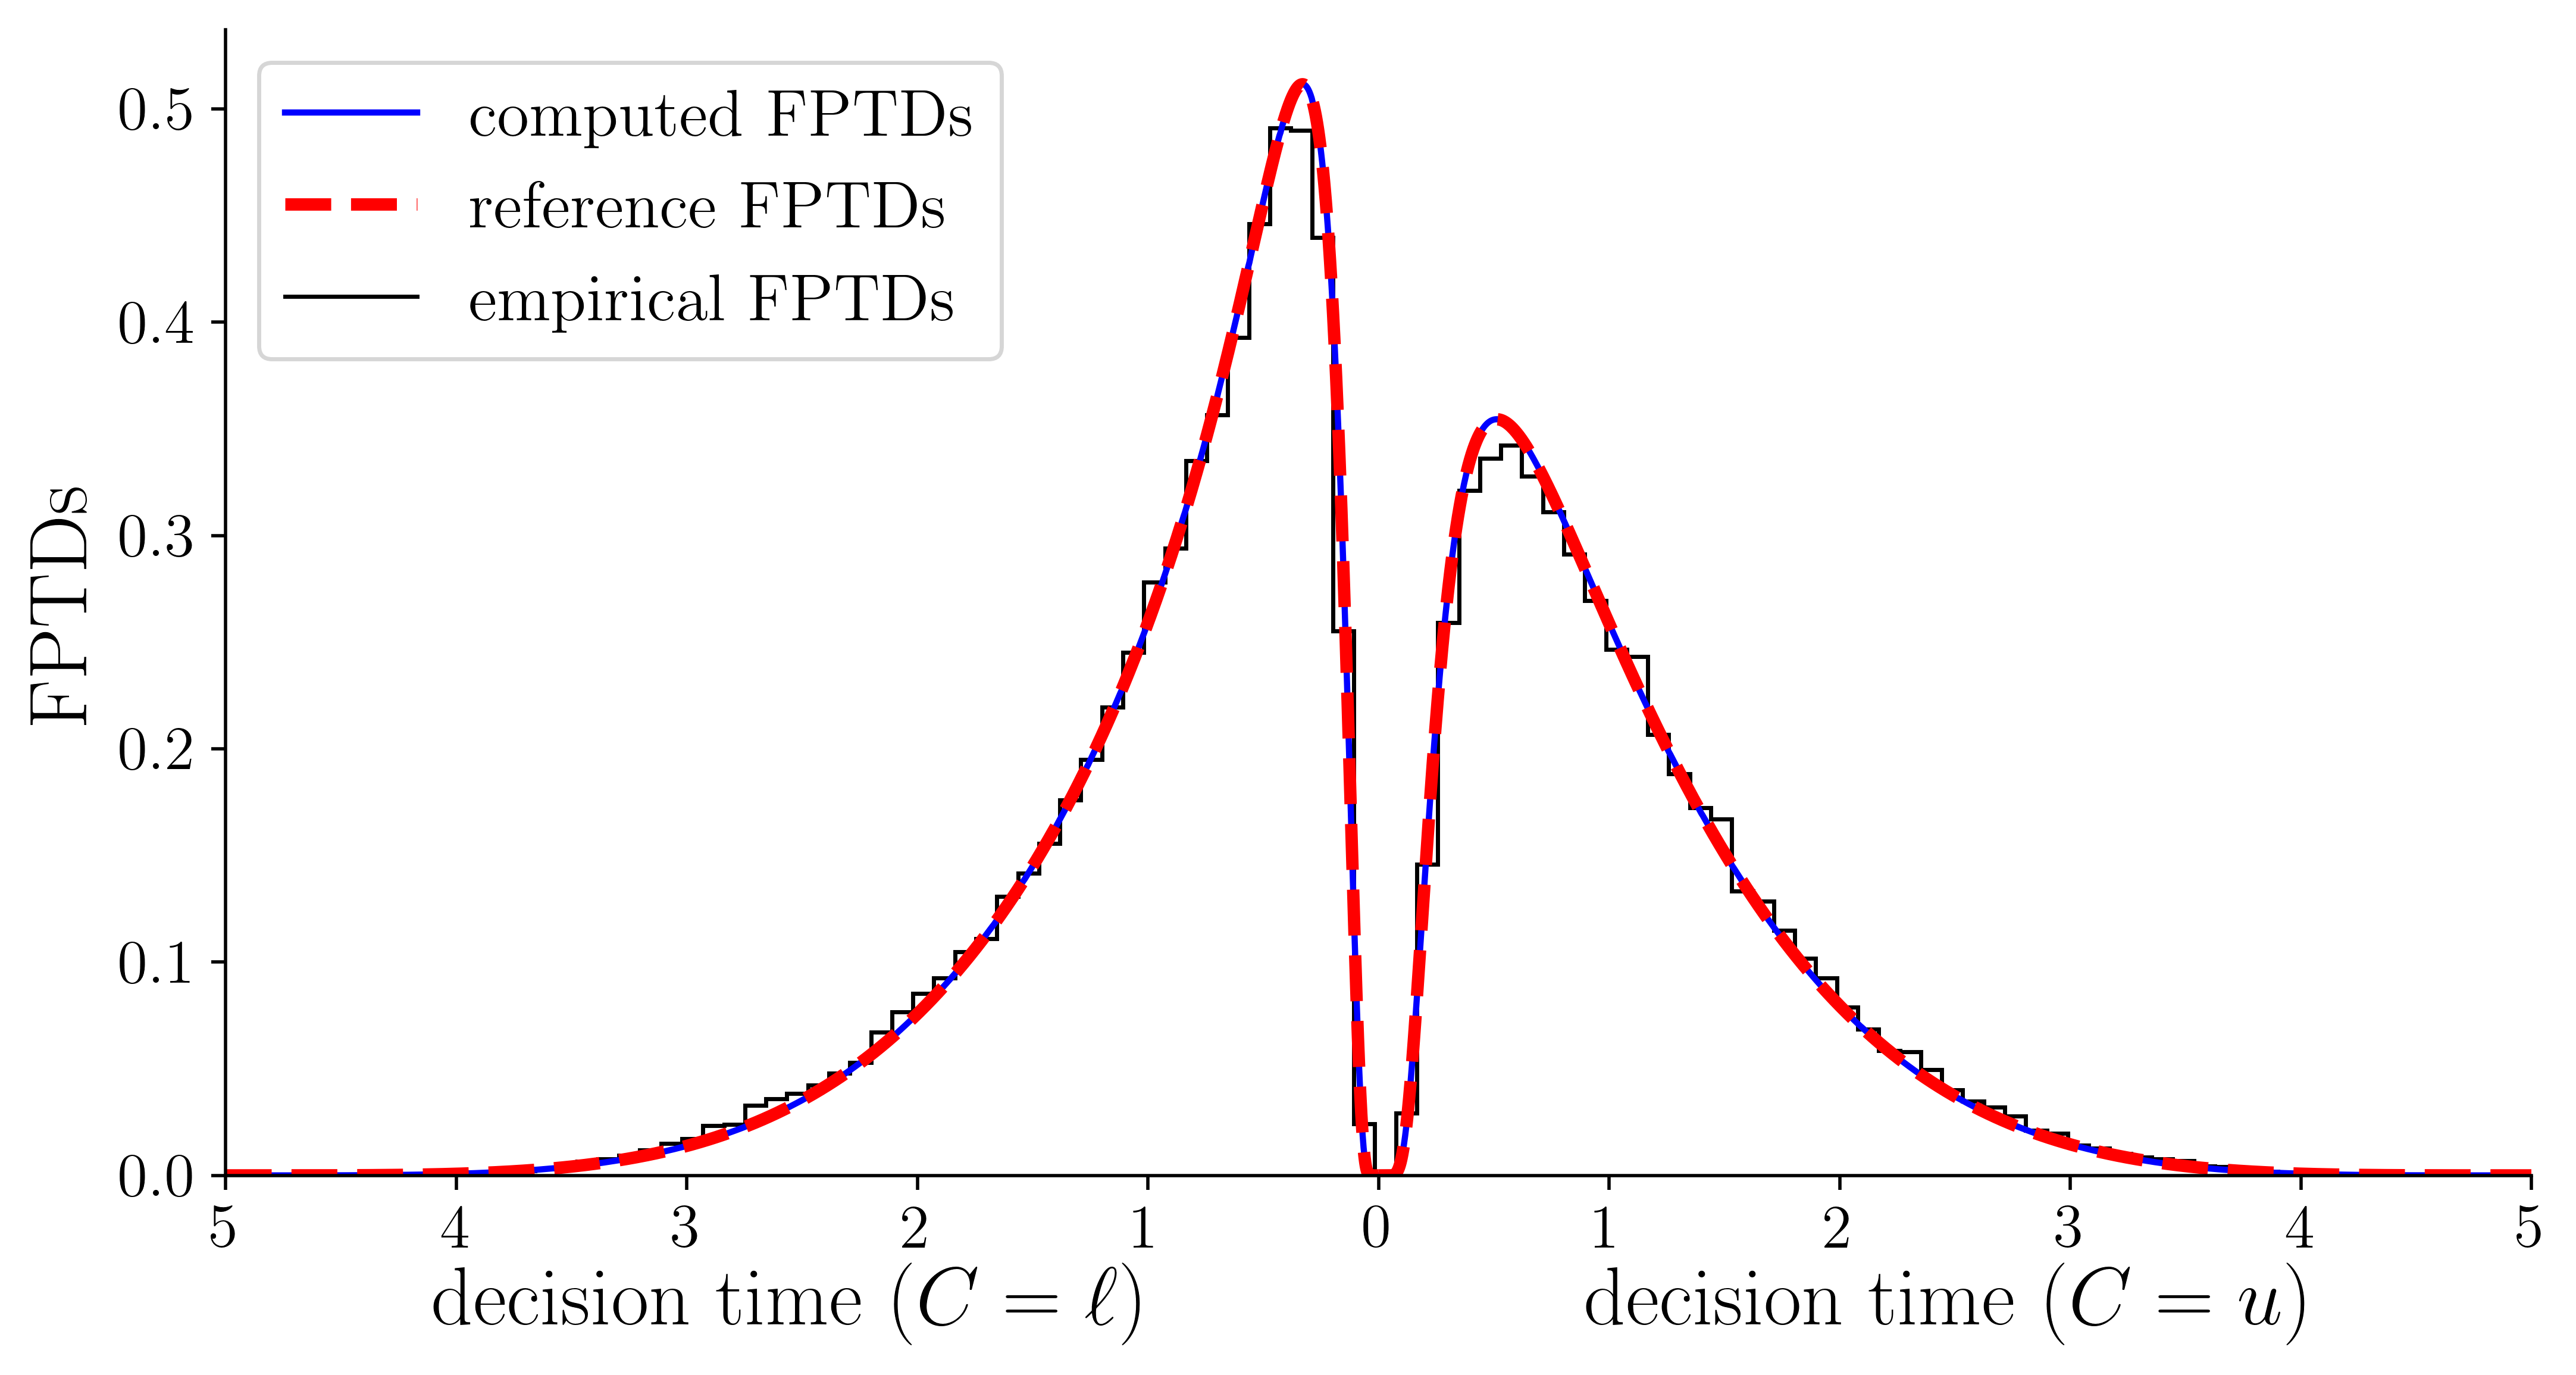

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=500)

ax.plot(ts, upper_fptds, c="b", linewidth=1.5, label="computed FPTDs")
ax.plot(-ts, lower_fptds, c="b", linewidth=1.5)
ax.plot(t, fu, c="r", linewidth=3, linestyle="--", label="reference FPTDs")
ax.plot(-t[::-1], fl[::-1], c="r", linewidth=3, linestyle="--")
ax.stairs(counts_t / num_fpt / dt_bin, bins_t, color="black", label="empirical FPTDs")


# ax.set_xlabel(r"$\tau$")
# ax.set_ylabel("FPTDs")
ax.text(-4.1, -0.07, r"decision time ($C=\ell$)", fontsize=20)
ax.text(0.9, -0.07, r"decision time ($C=u$)", fontsize=20)
ax.set_ylabel("FPTDs", fontsize=20)

ax.autoscale(tight=True, axis="x")

ax.set_xticks(np.arange(-5, 6, 1))
ax.set_xticklabels(np.hstack([np.arange(5, 0, -1), np.arange(0, 6, 1)]), fontsize=15)
yticks = np.arange(0, 0.6, 0.1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.1f}" for y in yticks], fontsize=15)
ax.spines[["right", "top"]].set_visible(False)

ax.legend(fontsize=16, loc="upper left")

# plt.savefig("ex6-figure.png", format="png", bbox_inches="tight", transparent=True)

plt.show()